# VAE model building

In [23]:
from keras.layers import Lambda,Input,Dense,Flatten,Conv2D,Conv2DTranspose
from keras.layers import Activation,BatchNormalization,Reshape
from keras.models import Model
from keras.datasets import fashion_mnist,mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def sampling(arg):
    arg = [z_mean,z_log_var]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),mean=0.0, stddev=1.0) # reparameterization trick
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# test dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train,-1)
X_test =  np.expand_dims(X_test,-1)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [4]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [121]:
channel = 1
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
input_shape = (img_rows,img_cols,channel)
batch_size = 128
latent_dim = 2
epochs = 100

### Encoder

In [6]:
inputs = Input(shape=input_shape)

x = Conv2D(16,3,strides=2,padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32,3,strides=1,padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64,3,strides=2,padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
before_flatten_shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean,z_log_var,z])
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Decoder

In [7]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(32, activation='relu')(latent_inputs)
x = Dense(64, activation='relu')(x)
x = Dense(before_flatten_shape[1]*before_flatten_shape[2]*before_flatten_shape[3], activation='relu')(x)
x = Reshape((before_flatten_shape[1],before_flatten_shape[2],before_flatten_shape[3]))(x)
x = Conv2DTranspose(64,3,strides=2,padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(32,3,activation='relu',strides=1,padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(16,3,activation='relu',strides=2,padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

outputs = Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
__________

### VAE

In [8]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

In [122]:
beta = 1 # 1 --> regular VAE
# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows * img_cols

kl_loss = -0.5 * K.sum(beta*(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [10]:
# vae.load_weights('vae_mnist.h5') # load all the weights for encoder and decoder when loading for vae

In [11]:
# with two dense layer
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

hist = vae.fit(X_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test, None))
# vae.save_weights('vae_fashion_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 226724    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         266657    
Total params: 493,381
Trainable params: 492,933
Non-trainable params: 448
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 184us/step - loss: 288.7050 - val_loss: 287.2572
Epoch 2/50
14336/60000 [======>.......................] - ETA: 6s - loss: 271.1888

KeyboardInterrupt: 

In [11]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

hist = vae.fit(X_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test, None))
# vae.save_weights('vae_fashion_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 124260    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         164193    
Total params: 288,453
Trainable params: 288,005
Non-trainable params: 448
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 180us/step - loss: 297.6883 - val_loss: 288.4740
Epoch 2/50
60000/60000 [==============================] - 9s 145us/step - loss: 271.1081 - val_loss: 271.8164
Epoch 3/50
60000/60000 [==============================] - 9s 145us/step - loss: 266.8557 - val_loss: 270.1294
Epoch 4/50
60000/

In [14]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
#     acc = [hist.history['acc'],hist.history['val_acc']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
    plt.title(model_name,fontsize=18)
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('')
    plt.tick_params(axis='both', labelsize=13)

In [13]:
training_plot(hist,'VAE_fMNIST')

NameError: name 'hist' is not defined

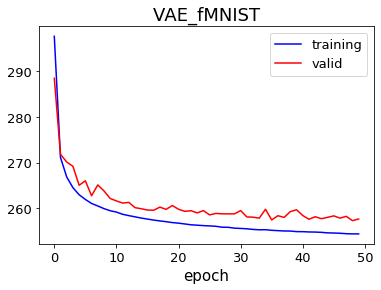

In [13]:
training_plot(hist,'VAE_fMNIST')

In [177]:
def plot_five_reconstruction(input_set,random_idx):
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    for row,flag in zip(axes,['in_img','out_img']): 
        for col,idx in zip(row,random_idx):
            original = input_set[idx]
            if flag == 'in_img':
                original_digit = original.reshape(img_rows,img_cols)
                col.imshow(original_digit,cmap='bone')
                col.set_title('original, idx={}'.format(idx))
            if flag == 'out_img':
                encoded_z = encoder.predict(np.expand_dims(original,0),batch_size=1)[2]
                predict = decoder.predict(encoded_z)
                decoded_digit = predict.reshape(img_rows,img_cols)
                col.imshow(decoded_digit,cmap='bone')
                col.set_title('reconstructed, idx={}'.format(idx))
            col.axis('off')

## Traing set reconstruction

[[1.9382391  0.33295015]]
[[-0.52116936 -0.03023315]]
[[-2.65569   -1.2205563]]
[[-2.3785903 -2.495417 ]]
[[-0.00077277 -0.6546884 ]]


array([[-0.00077277, -0.6546884 ]], dtype=float32)

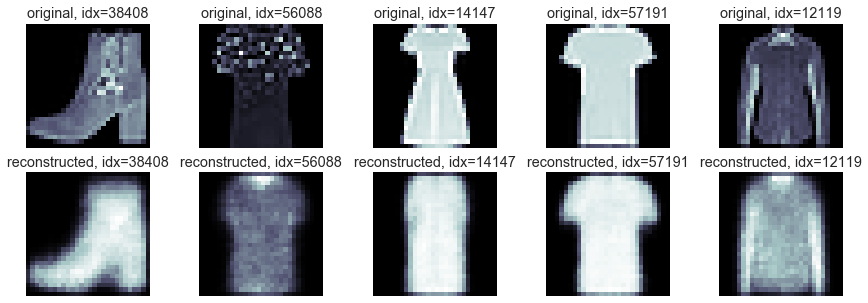

In [178]:
np.random.seed(100)
random_idx = np.random.randint(len(X_train),size=5,)
plot_five_reconstruction(X_train,random_idx)

## Test set reconstruction

[[ 1.4436488 -2.1777718]]
[[0.39338976 1.3034902 ]]
[[-1.4334109  -0.01662316]]
[[ 0.96618766 -2.1590557 ]]
[[-1.8028858  0.9413692]]


array([[-1.8028858,  0.9413692]], dtype=float32)

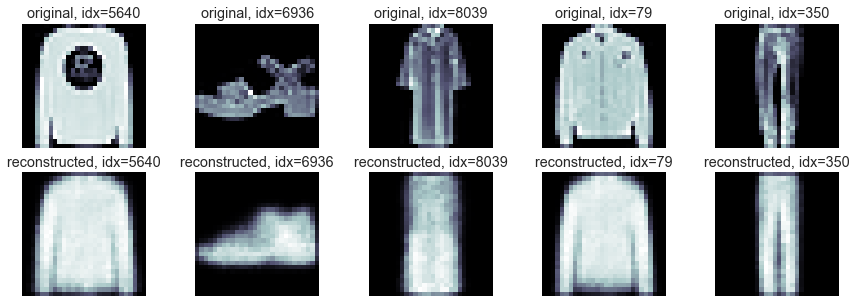

In [179]:
np.random.seed(100)
random_idx = np.random.randint(len(X_test),size=5,)
plot_five_reconstruction(X_test,random_idx)

## Interpolation on the test set

In [516]:
latent_space_df = pd.DataFrame(X_test_encoded,columns=['vector1','vector2'])
latent_space_df['label'] = y_test
latent_space_df.head()

,vector1,vector2,label
0,1.022453,1.474421,9
1,0.862985,-2.659559,2
2,-4.495635,0.678756,1
3,-2.332966,0.917474,1
4,0.483801,-0.844432,6


<Figure size 432x288 with 0 Axes>

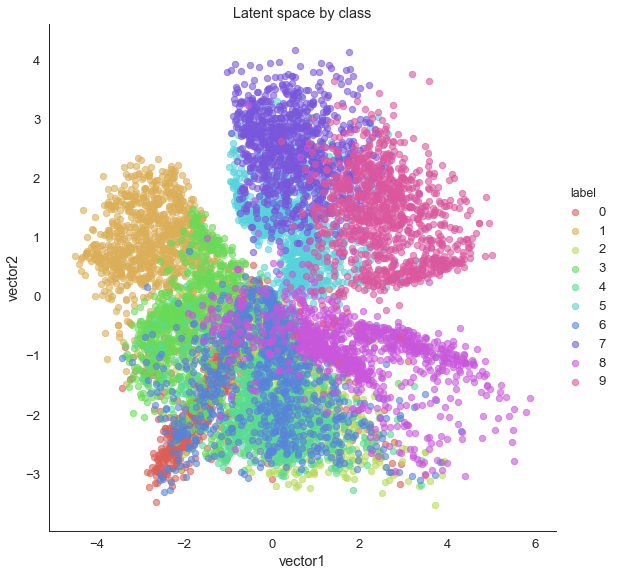

In [517]:
X_test_encoded = encoder.predict(X_test, batch_size=1)[2]

sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
plt.figure()
sns.lmplot('vector1','vector2',data=latent_space_df,hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 40},
            height=8,palette=sns.color_palette("hls",latent_space_df['label'].nunique()))
plt.title('Latent space by class')
plt.show()

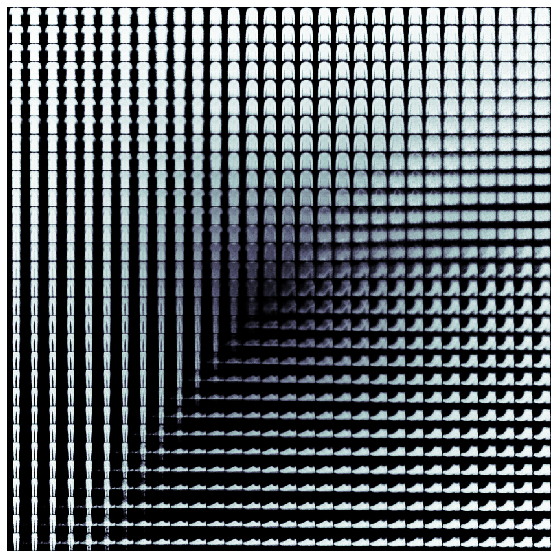

In [518]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='bone')
plt.axis('off')
plt.show()

In [525]:
def interpolation(img1,img2,step,plot=True):
    img1_encoded_z = encoder.predict(np.expand_dims(img1,0),batch_size=1)[2]
#     print('1: {}'.format(img1_encoded_z))   
    img2_encoded_z = encoder.predict(np.expand_dims(img2,0),batch_size=1)[2]
#     print('2: {}'.format(img2_encoded_z))
    step_size = (img2_encoded_z-img1_encoded_z)/step
#     print('step: {}'.format(step_size))

    step_list = [img1_encoded_z]
    for _ in range(step):
        img1_encoded_z = img1_encoded_z + step_size
        step_list.append(img1_encoded_z)
    if plot:
        fig,axes = plt.subplots(int(np.ceil((step+1)/5)),5, figsize=(5*4, int(np.ceil((step+1)/5))*4))
        for i,(ax,vector) in enumerate(zip(axes.flatten(),step_list)):
            predict = decoder.predict(vector).reshape(img_rows,img_cols)
            ax.imshow(predict)
            ax.axis('off')
            if i == 0:
                ax.set_title('From Image 1\n0%',fontsize=24,fontweight='bold')
            elif i == step:
                ax.set_title('To Image 2\n100%',fontsize=24,fontweight='bold')
            else:
                ax.set_title('step {}/{}\n{:.0f}%'.format(i,step,i*100/step),fontsize=24,fontweight='bold')
        plt.subplots_adjust(hspace=0.3,left=0.1, wspace=0.02)
        if (step+1)%5 != 0:
            for i in axes.flatten()[(step+1)-len(axes.flatten()):]:
                i.set_visible(False)
    return step_list

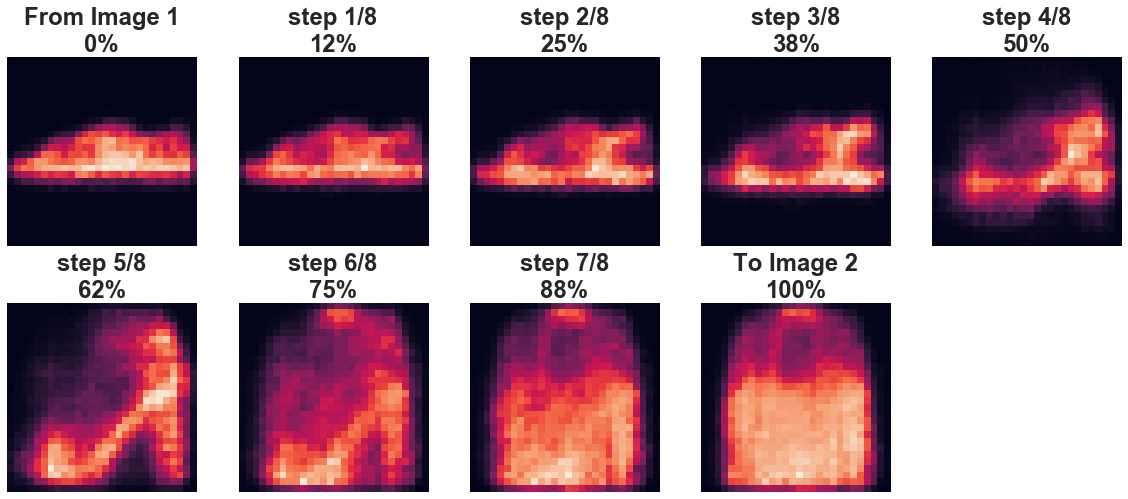

In [526]:
_ = interpolation(X_test[8],X_test[4],8,plot=True)